# Calculation of Wave Activity Flux (WAF) using python

This python code is based on the grads code (http://www.atmos.rcast.u-tokyo.ac.jp/nishii/programs/tnfxy-grads.ncep.nov2014.txt) that calculates the horizontal wave-activity flux derived by Takaya and Nakamura (1999, 2001).

## Import python packages

In [1]:
import sys

import xarray as xr
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
import matplotlib.pyplot as plt

sys.path

['C:\\Users\\YANG',
 'C:\\Users\\YANG\\anaconda3\\python38.zip',
 'C:\\Users\\YANG\\anaconda3\\DLLs',
 'C:\\Users\\YANG\\anaconda3\\lib',
 'C:\\Users\\YANG\\anaconda3',
 '',
 'C:\\Users\\YANG\\anaconda3\\lib\\site-packages',
 'C:\\Users\\YANG\\anaconda3\\lib\\site-packages\\locket-0.2.1-py3.8.egg',
 'C:\\Users\\YANG\\anaconda3\\lib\\site-packages\\win32',
 'C:\\Users\\YANG\\anaconda3\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\YANG\\anaconda3\\lib\\site-packages\\Pythonwin',
 'C:\\Users\\YANG\\anaconda3\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\YANG\\.ipython']

## Download data

Used data: monthly mean data of NCEP/NCAR reanalys 1

Variables: zonal and meridional wind (uwnd, vwnd), geopotential height (hgt)

The data are available at http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.html

In [2]:
from urllib import request
from os.path import isfile

url = 'ftp://ftp.cdc.noaa.gov/Datasets/ncep.reanalysis.derived/pressure/'
for fname in ['uwnd.mon.mean.nc', 'vwnd.mon.mean.nc', 'hgt.mon.mean.nc']:
    if isfile(fname):
        print(" --- skip ... "+fname)
    else:
        print(" --- download ... "+fname)
        request.urlretrieve(url+fname, fname)

 --- skip ... uwnd.mon.mean.nc
 --- skip ... vwnd.mon.mean.nc
 --- skip ... hgt.mon.mean.nc


## Read netcdf data using xarray

### Define global parameters

Level: 250 hPa

Basic state: climatology of monthly-mean field (November) averaged from 1980 to 2000.

Perturbation: monthly-mean anomalies in November 2014 (deviation from climatology).

In [3]:
plev = 250
year = 2014
month = 11 # November
yyyymm = "{:04d}-{:02d}".format(year, month)
start_date, end_date = ["1980-01", "2000-12"]

from scipy.constants import g, pi
Ra = 287 # gas constant in J/kg·K
a = 6400000 # Earth's radius

### Read data and extract the month

Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable


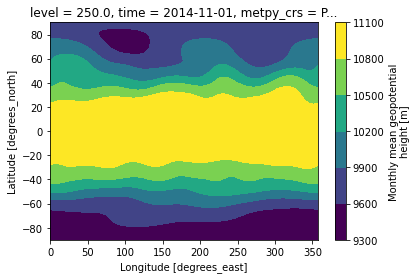

In [15]:
ds = xr.open_dataset("uwnd.mon.mean.nc").metpy.parse_cf()
uwnd = ds.uwnd.sel(time=ds.time.dt.month.isin([month]), 
                   level=plev).reindex(lat=list(reversed(ds.lat)))

ds = xr.open_dataset("vwnd.mon.mean.nc").metpy.parse_cf()
vwnd = ds.vwnd.sel(time=ds.time.dt.month.isin([month]), 
                   level=plev).reindex(lat=list(reversed(ds.lat)))

ds = xr.open_dataset("hgt.mon.mean.nc").metpy.parse_cf()
hgt = ds.hgt.sel(time=ds.time.dt.month.isin([month]), 
                   level=plev).reindex(lat=list(reversed(ds.lat)))

hgt.sel(time=yyyymm).squeeze().plot.contourf()

 ### Get monthly climatology and anomalies

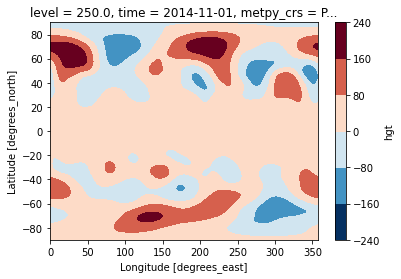

In [5]:
# Calculate monthly climatology for 1980-2000 years.
uclm = uwnd.sel(time=slice(start_date, end_date)).groupby("time.month").mean().squeeze()
vclm = vwnd.sel(time=slice(start_date, end_date)).groupby("time.month").mean().squeeze()
# Here, squeeze() indicates that the axis of length 1 (e.g., month) has been removed.
zclm = hgt.sel(time=slice(start_date, end_date)).groupby("time.month").mean()

# Calculate monthly anomalies of z250
za = hgt.groupby("time.month") - zclm
za = za.sel(time=yyyymm).squeeze()

za.plot.contourf()

### Get grid delta and f parameter

In [6]:
# Retrieve geographical coordinate
lons, lats = uclm.lon, uclm.lat
lon, lat = np.meshgrid(lons, lats)

# Coriolis parameter
f = mpcalc.coriolis_parameter(lat*units.degrees)

# Weights 
coslat = np.cos(np.deg2rad(lat))

# Central difference in longitude
dlon = np.gradient(np.deg2rad(lons))*2*units.rad
dlon = dlon[0]

# Central difference in latitude
dlat = np.gradient(np.deg2rad(lats))*2*units.rad
dlat = dlat[0]

dlon, dlat

(0.08726646 <Unit('radian')>, 0.08726668 <Unit('radian')>)

## Calculate WAF

### Get QG stream function

C:\Users\YANG\anaconda3\lib\site-packages\pint\quantity.py:1287: RuntimeWarning: divide by zero encountered in true_divide
  return self.__class__(other_magnitude / self._magnitude, 1 / self._units)


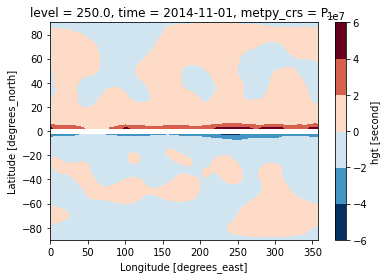

In [7]:
psia=g/f*za
psia.plot.contourf()

### Calculate wind speed of basic state

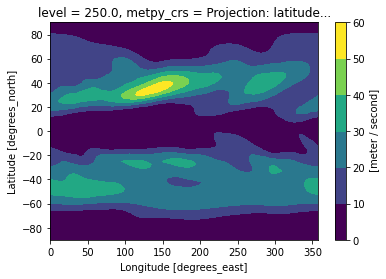

In [8]:
magU = mpcalc.wind_speed(uclm * units['m/s'], 
                         vclm * units['m/s'])
magU.plot.contourf()

### Calculate derivatives

See Eq. (38) of Takaya and Nakamura (2001)

In [25]:
#dpsidlon = np.gradient(psia.values, dlon)[1]
#ddpsidlonlon = np.gradient(dpsidlon, dlon)[1]
dpsidlon = mpcalc.first_derivative(psia.values, delta=dlon, axis=1)
ddpsidlonlon = mpcalc.first_derivative(dpsidlon, delta=dlon, axis=1)

#dpsidlat = np.gradient(psia.values, dlat)[0]
#ddpsidlatlat = np.gradient(dpsidlat, dlat)[0]
#ddpsidlatlon = np.gradient(dpsidlat, dlon)[1]
dpsidlat = mpcalc.first_derivative(psia.values, delta=dlat, axis=0)
ddpsidlatlat = mpcalc.first_derivative(dpsidlat, delta=dlat, axis=0)
ddpsidlatlon = mpcalc.first_derivative(dpsidlat, delta=dlon, axis=1)

termxu = dpsidlon*dpsidlon-psia.values*ddpsidlonlon
termxv = dpsidlon*dpsidlat-psia.values*ddpsidlatlon
termyv = dpsidlat*dpsidlat-psia.values*ddpsidlatlat

#fig, ax=plt.subplots(1,3, figsize=(12,5))
#for i, var in enumerate([ddpsidlonlon, ddpsidlonlon2, ddpsidlonlon-ddpsidlonlon2]):
#    xr.DataArray(var, coords=za.coords).plot.contourf(ax=ax[i])

### Get horizontal wave-activity flux (px and py terms)

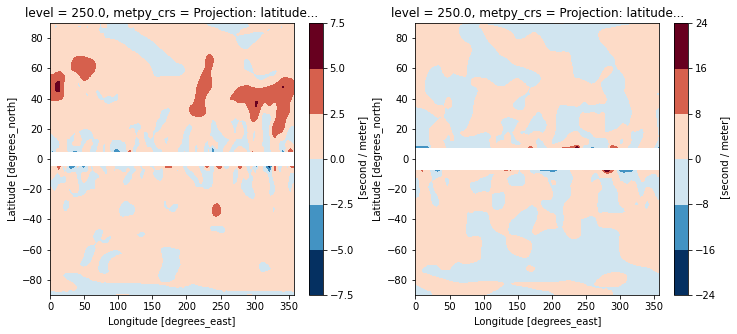

In [10]:
# ? coefficient
coeff=coslat*(plev/1000)/(2*magU) # p-level of 250 hPa is normalized by 1000 hPa

# x-component
px = coeff/(a*a*coslat)*( uclm*termxu/coslat + vclm*termxv)

# y-component
py = coeff/(a*a)*( uclm/coslat*termxv + vclm*termyv)

fig, ax=plt.subplots(1,2, figsize=(12,5))
px.plot.contourf(ax=ax[0])
py.plot.contourf(ax=ax[1])

### Draw figure

Plotting script in grads

Reference figure (https://www.atmos.rcast.u-tokyo.ac.jp/nishii/programs/Nov2014-TN01.png)

<img src="https://www.atmos.rcast.u-tokyo.ac.jp/nishii/programs/Nov2014-TN01.png" alt="drawing" width="500"/>